# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [285]:
import cv2 as cv
import numpy as np
import time
import tarfile
import os
from PIL import Image
from skimage import filters
from scipy import ndimage
from skimage import morphology

In [2]:
clk = np.array([9.72, 9.728, 9.72, 9.728, 9.72, 9.728, 9.72, 9.728, 9.72, 9.728])
mean_clk = np.mean(clk)
std_clk = np.std(clk)
print(mean_clk, std_clk)
clk

9.724 0.0039999999999995595


array([9.72 , 9.728, 9.72 , 9.728, 9.72 , 9.728, 9.72 , 9.728, 9.72 ,
       9.728])

In [3]:
A_1 = np.array([-7, 1,2])
A_2 = np.array([5, -11, 2])
A_3 = np.array([-1, 7, -10])
A_4 = np.array([1, 1,2])

A = np.array([A_1, A_3 , A_4])
b = np.array([[4, 4, 4]])
c = np.linalg.inv(A) @ b.transpose()
c

array([[0.],
       [2.],
       [1.]])

In [4]:
#data_base_path = os.path.join(os.pardir, 'data')
data_base_path = os.path.join('/home/my_notebooks/iapr', 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

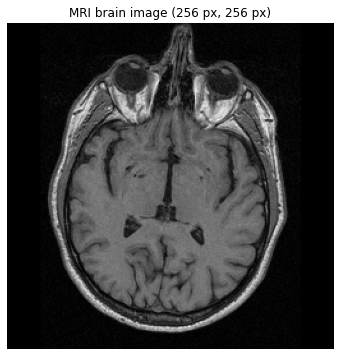

In [5]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

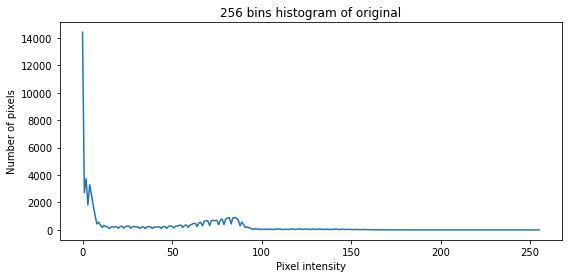

In [6]:
# plot the histogram of image
hist_brain_im = cv.calcHist([brain_im],[0],None,[256],[0,256])
plt.figure(figsize=(9, 4))
plt.plot(hist_brain_im)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram of original')
plt.show()

In [7]:
def plotMultipleImages(nrows, ncols, images, titles):
    fig = plt.figure(figsize=(14,7))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
    plt.show()

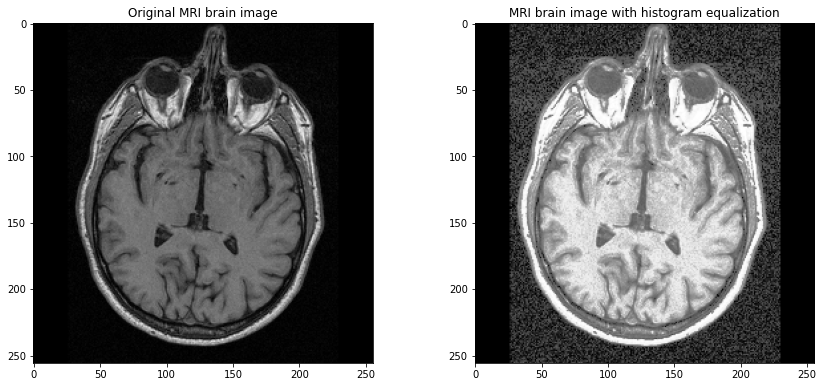

In [8]:
# histogram equalizer
equ_brain_im = cv.equalizeHist(brain_im)
#hist_equal_brain_im = cv.calcHist([equ_brain_im],[0],None,[256],[0,256])

titles = ['Original MRI brain image', 'MRI brain image with histogram equalization']
images = [brain_im, equ_brain_im]
plotMultipleImages(1, 2, images, titles)

In order to reduce the effects of noise on further processing, we decided to convolve the image with two low-pass Median filters  which are Gaussian and  kernels respectively to remove the image noise and imrpove its quality.

As the results show, with low-pass filter convolution, the noise-free images become blurry as high frequency details (edge + noise) are removed. images looks quite similiar. However, the median filter can keep the contours but gaussian filter cannot. So the resultant image convolved with median filter is prefered. 

In order to compute the size of brain (without the skull) in pixels, differnet methods are used to segment the brain object from the original image. Before we apply different algorithms to implement the image segmentation, the original MRI image should be pre-processed to improve its quality so that we can analyse it in a better way. Since each algorithm has different characteristics, differnet pre-processing methods will be considered on a case-by-case basis.

### 1.2 Region growing (5pts)

#### 1.2.1 Pre-processing

The basic idea of region growing is to assemble pixels with similar properties to form regions. There are different criteria available for determining region membership. In this lab, we use the intensity difference between neighbor or connected pixels as the growth criteria. The goal is to extract the gray area of brain from skull (relatively bright = high intensity, but mixed with gray parts) and backgroud (totally dark = low intensity). Our idea is, if the intensity difference of these three objects can be increased further, the brain can be easier identified so that the performance of the region growth should be better. Thus, we firstly plot the histogram of provided MRI brain image to check the pixel intensity distribution.

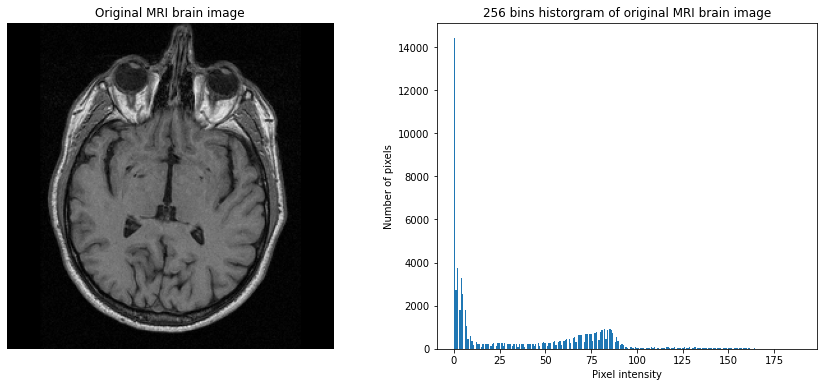

The intensity value of brain center is 79


In [83]:
# Draw image histogram 
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off') 
ax[1].hist(brain_im.ravel(), bins=256) 
ax[1].set_title('256 bins historgram of original MRI brain image')
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')
plt.show()
print('The intensity value of brain center is {}'.format(brain_im[150,150]))

As the histogram shows, the following observations can be obtained:
1. The bars are spread out over the x-axis, which means the histogram equalization may not be required in this part as the image contrast is enough; 
1. It's possible to identify two clusters of pixels. The first cluster around 0-intensity should be the dark background; The 2nd cluster covers the intensity valus from 50 to 100. The intensity value of brain center we found is 79, which suggests that the 2nd cluster mainly corresponds to the gray brain.
1. The remaining pixels could be, for example, the overlapping parts of the brain and skull, noise, or transition areas between background and foreground.

Thus, we firstly considered the x pre-preocessing methods:
- As the distribution of histogram is nicely bimodal, we can apply a threshold range to filter out the parts that are not of interest (i.e., the background, the brighter parts of the skull) so that the region growing used in later can easier capture the gray brain that remains in the image. 
- To address the noise issue. the low-pass filters, median kernel, is to remove any possible noise off the image while preserving the countours of objects.

(Note: These pre-processing methods are conducted several times, and all parameters (i.e., kernel size and threshold value) are selected carefully to keep most relevant parts of our analysis)

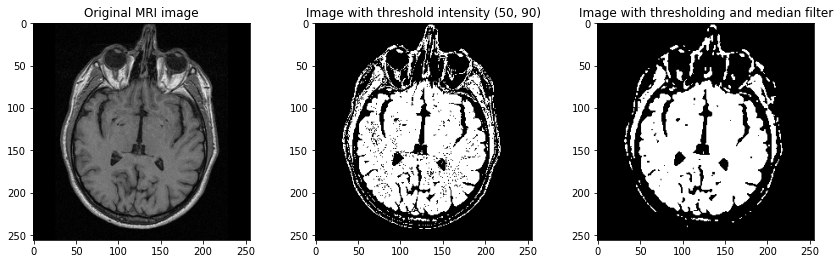

In [178]:
# threshold to extract intensity values between to
thres_brain_im = cv.inRange(brain_im,54,90)

# median filter with kernel = 3
median_brain_im = cv.medianBlur(thres_brain_im, 3)

titles = ['Original MRI image', 'Image with threshold intensity (50, 90)', 'Image with thresholding and median filter']
images = [brain_im, thres_brain_im, median_brain_im]

plotMultipleImages(1, 3, images, titles)

As the results show, after applying the pre-processing, certain brighter parts of the skull are filtered out and the connection between brain and skull is weaken. Now the image is cleaner than before.

#### 1.2.2 Implementing region growing

In this part, we used our own region growing function to segment the brain. Specifically, our implementation consists of 3 steps:
1. Set the seed pixel position. As our goal is to extract the brain part from image, we put the seed in the center part of brain (i.e., height=150, width=150) which makes the brain region grow easier and faster.
1. Taking the seed as center, consider 4-connected neighbor pixels. For neighbors, that can meet the growth criteria and are not labelled before, will be asigned with the same label as seed. Furthermore, these neighbors will be used as new seeds for growing current region further. For neighbors that are not consistant with seed, we just ignore them. 
1. Repeating above steps until the new_seeds list becomes empty, whcih means that all pixels included in the brain region have been collected.


Note: (1) Becasue the current image is in binary format (i.e., 0 for background and 255 for brain), the growth criteria we used is that only neighbors that have intensity of 255 will be merged into the region where the seed is located. (2) We also tested with the 8-connectivity neighbors to check if the accuracy of segmentation could be further improved. Then the results showed that, in this case, the improved accuracy is quite limited and the execution time of 8-connectivity case is 1.96 times longer than before. Thus, we finally decided to use 4-connectivity neighbor pixels only.

The total area of brain is 16409 pixels from the region growing method.


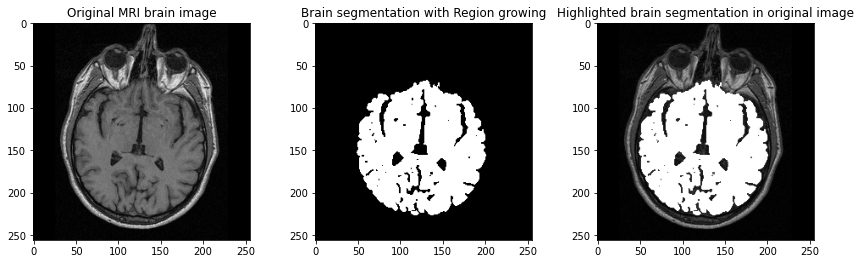

In [ ]:
start_seed = (150, 150)

def regionGrowing(start_seed, original_im, connect=4):
    
    # matrix to store gray value of labelled pixel
    regionMask_im = np.zeros(original_im.shape)
    
    if connect == 4:
        # relative position of connected pixels: left, right, above, below
        neighbor_pos = [(0, -1), (0, 1), (1, 0), (-1, 0)]
    if connect == 8:
        # connected neighbor pixels: left, right, above, below, diagonal
        neighbor_pos = [(0, -1), (0, 1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
        
    new_seeds = [start_seed]
    labelled_point = [start_seed]
    
    while(len(new_seeds) != 0):
        
        seed = new_seeds.pop(0) # pop up the 1st seed
        regionMask_im[seed] = 255 # set seed pixel to white
        labelled_point.append(seed)
        
        # traverse all neighbors
        for pos in neighbor_pos:
            # get neighbor position and check if it is inside the image
            neighbor = (seed[0] + pos[0], seed[1] + pos[1])
            if neighbor[0] < 0 or neighbor[0] >= original_im.shape[0] or neighbor[1] < 0 or neighbor[1] >= original_im.shape[1]:
                continue
            # check constrast difference & assigin label
            if (np.abs(int(original_im[seed]) - int(original_im[neighbor]))) == 0 and neighbor not in labelled_point and neighbor not in new_seeds:
                new_seeds.append(neighbor)
        
    return regionMask_im, len(labelled_point)


regionMask_im, brain_area = regionGrowing(start_seed, median_brain_im, 4)

regionMask_im = regionMask_im.astype(np.uint8)


print('The total area of brain is {} pixels from the region growing method.'.format(brain_area))

brain_out = np.copy(brain_im)
brain_out[regionMask_im==255] = 255

images = [brain_im, regionMask_im, brain_out]
titles = titles = ['Original MRI brain image', 'Brain segmentation with Region growing', 'Highlighted brain segmentation in original image']
plotMultipleImages(1, 3,images, titles)

As the final result shows, the brain part (without the skull) has been successfully extractd from the original MRI image. 

### _Comment:_ 
The region growing algorithm is a simple method, which only needs a small number of seed points to represent the property we want, then grows the region by using a recursive process. In our case, the segmentation result is quite reliable. However, it also has some limitations that we found in this lab. For example, the variation of intensity may cause result in holes or oversegmentation. Typically, the MRI images have a good bimodal intensity distribution, so a simple threshold processing can effectively weaken the connection between the brain and the skull, and then the growing region starting from the center of the brain will not contain the skull object by a weak connection. However, 
Unless image has had a threshold function applied, a continuous path of points related to color may exist, which connects any two points in the image.

### 1.3 Contour detection (5pts)

In Image Processing, an edge refers to a set of continuous points where a significant local change in the image brightness can be observed, which is usually associated with a discontinuities in either the image intensity or the first derivative of the image intensity. When these edge points are joining to form a closed boundary, the contour is obtained which sepertes two homogeneous regions. And the process of identifying and locating sharp discontinuities in an image is known as edge detection. Many edge-based algorithms are to pation a digital image into multiple regions based on detecting abrupt changes in charactristics such as tecture, intensity, or color. For example, some commonly used methods, Robers operator, Sobel operator and Previtt operator, compute or estimate the 2-D intensity gradient vector at each pixel by convolving image with horizontal and vertical derivative filters. In this part, we choose **Sobel operator** as the contour dtector as it has the advantage of providing differentiating (which gives the edge response) and smoothing (which reduces noise) concurrently. 

Before we implement contour detection, it should be noted from the process of Part-1.2 that the original MRI image is quit noisy (i.e. The noise reduction provided by the Sobel operator itself may not be sufficient). Since both the edges and noise hold high-frquency content, an appropriate filtering (**i.e. Gaussian smoothed**) is essential in pre-processing to reduce potential problems caused by noise such as fake edge detection, edge localizytion or missing true edges.

In general, we can identify 3 kinds of edges from the results, (1) Strong edges that have an intensity so high that we are sure they contribute to the brain object, such as the edges of skull and part of brain tissue; (2) Weak edges that have relatively low intensity values but are still visible, such as the light pattern of brain; (3) Some irrelevant edges (i.e., residual noise) contained in the background may not be visible to us from the image, but they are present. Thus our goal is to extract the edges of the brain tissue that define the area of entire brain (without skull). 

However, after trying different extraction methods (i.e. thresholding with fine-tuning parameters), We found that the irrelevant edges were easily eliminated, but it was impossible to separate the edges of the skull from the edges of the brain tissue because their edges had similar intensities. Thus, we decided to temporarily preserve the edges of skull and brain tissue and remove irrelevant edges only by using a simple threshold method. The threshold value was chosen to be the mean intensity of Sobel_brain_im to keep the most relevant edges for our further analysis.

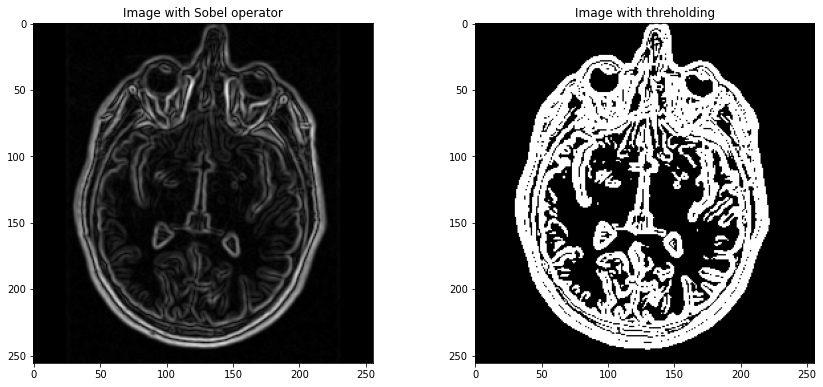

In [281]:
# Smooth the image for better edge detection
Gaussian_brain_im = cv.GaussianBlur(brain_im, (5,5), 0)

#images = [brain_im, Gaussian_brain_im]
#titles = titles = ['Original MRI brain image', 'Image with Gaussian smoothed']
#plotMultipleImages(1, 2,images, titles)

# Sobel Edge Detection
Sobel_brain_im = filters.sobel(Gaussian_brain_im)

# threshold
_ ,thres_brain_im = cv.threshold(Sobel_brain_im, np.mean(Sobel_brain_im)*1, 255,cv.THRESH_BINARY)

images = [Sobel_brain_im, thres_brain_im]
titles = titles = ['Image with Sobel operator', 'Image with threholding']
plotMultipleImages(1, 2,images, titles)

The results show that the skull is mainly composed of white pixels, while the brain tissue is mainly composed of black pixels. We then realized that the brain tissue can be extracted by subtracting the current image (caption: 'image with thresholding') from a binary image consisting of black background and a white brain (skull + brain tissue). To achieve this, the function `binary_fill_holes()` is used to an binary brain image. Then  operation `remove_small_objects()` is used to remove residual skull pixels. Finally, the morphological dilation is used to fill undesired holes in brain tissue.

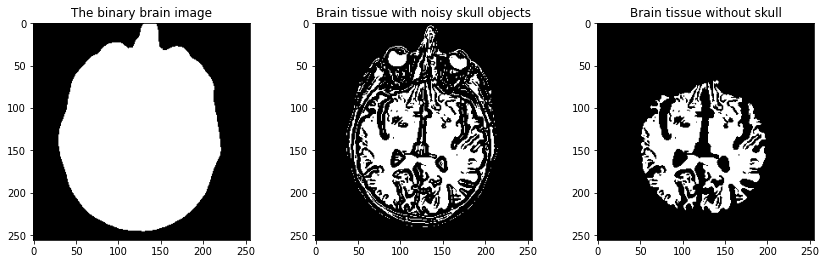

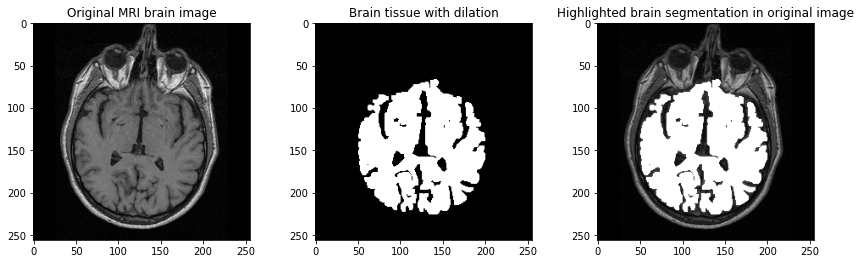

In [307]:
# Extract entire brain object
bi_brain_im = ndimage.binary_fill_holes(thres_brain_im).astype(np.uint8)

# compute the difference
diff_brain_im = np.abs(thres_brain_im - bi_brain_im*255)

# remove undesired objects
clean_brain_im = morphology.remove_small_objects(diff_brain_im.astype(bool), min_size=300)

# fill small holes contained in brain tissue
kernel = np.ones((4,4),np.uint8)
dilation = cv.dilate(clean_brain_im.astype(np.uint8),kernel,iterations = 1)

# display results
images = [bi_brain_im, diff_brain_im, clean_brain_im]
titles = ['The binary brain image',  'Brain tissue with noisy skull objects', 'Brain tissue without skull']
plotMultipleImages(1, 3,images, titles)

# compare to original MRI image
brain_out = np.copy(brain_im)
brain_out[dilation==1] = 255

images = [brain_im, dilation, brain_out]
titles = titles = ['Original MRI brain image', 'Brain tissue with dilation', 'Highlighted brain segmentation in original image']
plotMultipleImages(1, 3,images, titles)

### 1.4 Additional method (5pts)

In [ ]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [33]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


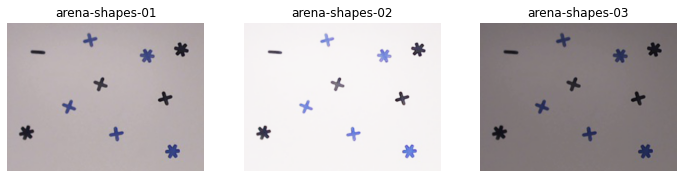

In [34]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion